In [269]:
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install wordcloud
# !pip install textblob
# !pip install sklearn

import pandas as pd
import numpy as np
import csv
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hossein89\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 0. Read Input files
The primary step for data analysis is to read the inout the data. To this aim, the the given files are changed to csv format files. Therafter, the inout files are tranferred to a data frame.

In [270]:
#read the input files
generic_tweets_df = pd.DataFrame()
cols_generic=['sentiment','id','date','query_string','user','text']
generic_tweets_df = pd.read_csv('generic_tweets.csv',header=0, names=cols_generic)
generic_tweets_df.tail()

,sentiment,id,date,query_string,user,text
199995,4,1693956088,Mon May 04 00:27:13 PDT 2009,NO_QUERY,FelineBred,"@jvdouglas haha, no, the remark on maternity ..."
199996,4,1693956096,Mon May 04 00:27:14 PDT 2009,NO_QUERY,softthistle,@altitis and to you!
199997,4,1693956099,Mon May 04 00:27:14 PDT 2009,NO_QUERY,elysion32,Okie doke!! Time for me to escape for the Nort...
199998,4,1693956134,Mon May 04 00:27:14 PDT 2009,NO_QUERY,fancyjessy,"finished the lessons, hooray!"
199999,4,1693956160,Mon May 04 00:27:14 PDT 2009,NO_QUERY,noraezan,Some ppl are just fucking KP0. Cb ! Stop askin...


In [271]:
US_airline_tweets_df = pd.DataFrame()
US_airline_tweets_df = pd.read_csv("US_airline_tweets.csv",header=0)
US_airline_tweets_df.tail()

,id,sentiment,negative_reason,user,retweet_count,text
11536,5.695880e+17,negative,Cancelled Flight,RussellsWriting,0,@AmericanAir my flight was Cancelled Flightled...
11537,5.695880e+17,negative,Late Flight,GolfWithWoody,0,@AmericanAir right on cue with the delaysðŸ‘Œ
11538,5.695880e+17,positive,NaN,KristenReenders,0,@AmericanAir thank you we got on a different f...
11539,5.695870e+17,negative,Customer Service Issue,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...
11540,5.695870e+17,negative,Customer Service Issue,SraJackson,0,"@AmericanAir you have my money, you change my ..."


In [4]:
#Creating the list of stop words using the given file of "stop_words.txt"
with open('stop_words.txt', 'r') as f:
    default_stop_words = [line.strip() for line in f]
default_stop_words[:5]


['a', 'able', 'about', 'above', 'abst']

In [5]:
#Creating the corpus using the given file of "corpus.txt"
corpus_df = pd.DataFrame()
with open('corpus.txt', 'r') as f:
    for line in f:
        corpus_df = pd.concat( [corpus_df, pd.DataFrame([tuple(line.strip().split('\t'))])], ignore_index=True )
corpus_df.tail()

,0,1
2472,yucky,-2
2473,yummy,3
2474,zealot,-2
2475,zealots,-2
2476,zealous,2


# 1. Data Cleaning
The first step is to clean the data and remove any noise and meaningless characters. Through the **15 steps** given below the data is cleaned and ready for further analysis. Each step is specified with a number which you can find its relevent code in the body of the cleaning function below.
- (1) Replacing html character codes with ASCII equivalent: This is done using the beautiful soup package
- (2) Replacing unicode characters
- (3) Removing the URLs
- (4) **(BONUS)** Removing the web addresses which are written using the "www"
- (5) Removing the hashtags: removing the # character
- (6) Removing mentions: removing the @ character and the word attached
- (7) Removing emojies
- (8) Changing all words to Lowercase
- (9) **(BONUS)** Handle the nagative verbs which can be written in two formats, such as "don't" and "do not"
- (10) Removing the html tags and attributes keeping the words only
- (11) **(BONUS)** Correcting the spelling problems: This is done using the TextBlob package
- (12) Tokenizing the tweets into words and removing the Stop words: For this purpose the library of nltk stopwords is used.
- (13) **(BONUS)** Stemming the words: Thsi is done using the nltk porter stemming package
- (14) removing the words with less than 3 letters
- (15) Joining the tokens together to form the cleaned tweet


In [272]:
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob

tokenizer = WordPunctTokenizer()

negative_verbs_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"cannot","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

negative_verbs_handler = re.compile(r'\b(' + '|'.join(negative_verbs_dic.keys()) + r')\b')

# a function to clean a singel piece of text
def clean_text(text):
    # (1) Replacing html character codes with ASCII equivalent
    soup = BeautifulSoup(text, 'lxml')
    html_converted_to_ASCII = soup.get_text()
    try:
        # (2)Clean article replacing unicode characters.
        unicode_cleaned = html_converted_to_ASCII.decode("utf-8-sig").replace(u"\ufffd", "?").replace(u'\u2018', u"'").replace(u'\u2019', u"'").replace(u'\u201c', u'"').replace(u'\u201d', u'"')
    except:
        unicode_cleaned = html_converted_to_ASCII
    
    # (3) Remove URLs 
    nourl_result = re.sub(r'https?://[A-Za-z0-9./]+', "", unicode_cleaned)
    # (4) Remove websites 
    noweb_result = re.sub(r'www.[^ ]+', '', nourl_result)
    # (5) Remove Hash tags 
    nohashtag_result = re.sub(r"(?:\#+)",'', noweb_result)
    # (6) Remove mentions 
    nomentions_result = re.sub(r'(?:@[\w_]+)', '', nohashtag_result)
    # (7) Remove emojies 
    noemoji_result = re.sub(r"""
            (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
            )""", '', nomentions_result)
    
    # (8) Conver all letters to lower case
    lower_case = noemoji_result.lower()
    
    # (9) handle the negative verbs
    negative_verbs_handled = negative_verbs_handler.sub(lambda s: negative_verbs_dic[s.group()], lower_case)
    
    # (10) Remove html tags and attributes and only keep the words
    letters_only = re.sub("[^a-zA-Z]", " ", negative_verbs_handled)
    
    # (11) Correct the spelling problems
    corrected_text = str(TextBlob(letters_only).correct())
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tokenizer.tokenize(corrected_text)
    
    # (12) Removing the stopwords 
    cachedStopWords = stopwords.words("english")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # (13) Stemming the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
#     tokens =(list(map(lambda token: WordNetLemmatizer().lemmatize(token), words)))

    
    # (14) Removing all the words whose length is less than a minimum (e.g., 3)
    min_length = 3
    filtered_tokens = list(filter(lambda token: len(token) >= min_length, tokens))

    # (15) Join the tokens togethe to create the tweet again
    reconstructed_text = (" ".join(filtered_tokens)).strip()  
    
    return (reconstructed_text)


### Show an example of how the clean_text function works

In [40]:
test_text="❤️ &amp; :D @lasada grab #proud shouldn't cannot ? the http://github.com/tthustla ali@yahoo.ir  www.google.com"

test_result=(clean_text(test_text))

print((test_result))


grab proud cannot ali


## 1.1.  Clean the text of 200,000 generic tweets

In [100]:
nums= list(np.arange(0, len(generic_tweets_df), 5000))
nums.append(len(generic_tweets_df))

cleaned_text_list = []
for k in range(0,len(nums)-1):
    for i in range(nums[k],nums[k+1]):                                                                  
        cleaned_text_list.append(clean_text(generic_tweets_df['text'][i]))
    
clean_generic_tweets_df = pd.DataFrame(cleaned_text_list,columns=['cleaned_text'])
clean_generic_tweets_df['date'] = generic_tweets_df.date
clean_generic_tweets_df['sentiment'] = generic_tweets_df.sentiment

clean_generic_tweets_df.to_csv('clean_generic_tweets.csv',encoding='utf-8')
clean_generic_tweets_df.tail()


,cleaned_text,date,sentiment
199995,hata remark patern leav fire,Mon May 04 00:27:13 PDT 2009,4
199996,,Mon May 04 00:27:14 PDT 2009,4
199997,time escap north mass turn folk,Mon May 04 00:27:14 PDT 2009,4
199998,finish lesson doorway,Mon May 04 00:27:14 PDT 2009,4
199999,fuck law love boyfriend,Mon May 04 00:27:14 PDT 2009,4


In [273]:
clean_generic_tweets_df = pd.read_csv('clean_generic_tweets.csv',index_col=0)
clean_generic_tweets_df.tail()

,cleaned_text,date,sentiment
199995,hata remark patern leav fire,Mon May 04 00:27:13 PDT 2009,4
199996,NaN,Mon May 04 00:27:14 PDT 2009,4
199997,time escap north mass turn folk,Mon May 04 00:27:14 PDT 2009,4
199998,finish lesson doorway,Mon May 04 00:27:14 PDT 2009,4
199999,fuck law love boyfriend,Mon May 04 00:27:14 PDT 2009,4


### Coputing the number of characters per tweet

In [274]:
length = []
for i in range(0, len(clean_generic_tweets_df)):
    if (str(clean_generic_tweets_df['cleaned_text'][i]))=='nan':
        char_count = 0
    else:
        char_count = (len(str(clean_generic_tweets_df['cleaned_text'][i])))
        
    length.append(char_count)

clean_generic_tweets_df['character_count'] = length
clean_generic_tweets_df.tail()

,cleaned_text,date,sentiment,character_count
199995,hata remark patern leav fire,Mon May 04 00:27:13 PDT 2009,4,28
199996,NaN,Mon May 04 00:27:14 PDT 2009,4,0
199997,time escap north mass turn folk,Mon May 04 00:27:14 PDT 2009,4,31
199998,finish lesson doorway,Mon May 04 00:27:14 PDT 2009,4,21
199999,fuck law love boyfriend,Mon May 04 00:27:14 PDT 2009,4,23


## 1.2.  Find the airline for each tweet and clean the text of airline tweets
To find the airline of each tweet, the first mentioned airline is considered to be the targetted airline. To this aim a series of codes are devloped as provided below. Each step is specified with a number which you can find its relevent code in the body of the cleaning function below.

- (1) Create a dictionary of airlines and their tweeter accounts
- (2) Remove all non letters in the tweets, except the @ sign
- (3) Create the list of words which come immediatelt after the @ sign
- (4) Create the list of airlines that have been mentioned in the tweet
- (5) Choose the first mentioned airline as the airline of interest for each tweet
- (6) Clean the text of the tweet

In [328]:
nums= list(np.arange(0, len(US_airline_tweets_df), 1000))
nums.append(len(US_airline_tweets_df))
# nums=[0,4,8,120]

all_mentions_list = []
cleaned_text_list = []
# (1) Create a dictionary of airlines and their tweeter accounts
US_airlines_twitter_account ={'usairways':'US Airways', 'virginamerica':'Virgin America', 
                              'southwestair':'Southwest Air', 'united':'United Airlines',
                              'americanair':'American Airlines', 'jetblue':'JetBlue',
                              'delta':'Delta', 'deltaassist':'Delta','spiritairlines': 'Sprit Airlines'
                             }

for k in range(0,len(nums)-1):
    for i in range(nums[k],nums[k+1]):
        # (2) Remove all non letters in the tweets, except the @ sign
        letters_only = re.sub("[^a-zA-Z@]", " ", US_airline_tweets_df['text'][i])
        # (3) Create the list of words which come immediatelt after the @ sign
        mentions_list = re.findall("(^|[^@\w])@(\w{1,15})", letters_only)
        
        # (4) Create the list of airlines that have been mentioned in the tweet
        templist=[]
        for j in range(0,len(mentions_list)):
            templist.append(mentions_list[j][1].lower()) 
        
        airline_list=[]
        for l in range(0,len(templist)):
            try:
                airline_list.append(US_airlines_twitter_account[templist[l]])
            except:
                pass
        
        # (5) Choose the first mentioned airline as the airline of interest for each tweet
        try:
            all_mentions_list.append(airline_list[0])
        except:
            print('The airline from the followig tweet cannot be identifed:','"',US_airline_tweets_df['text'][i],'"')
            all_mentions_list.append('')
        
        # (6) Clean the text of the tweet
        cleaned_text_list.append(clean_text(US_airline_tweets_df['text'][i]))
        
        
clean_airline_tweets_df = pd.DataFrame(cleaned_text_list,columns=['cleaned_text'])
clean_airline_tweets_df['airline'] = all_mentions_list

clean_airline_tweets_df['sentiment'] = US_airline_tweets_df.sentiment
clean_airline_tweets_df['negative_reason'] = US_airline_tweets_df.negative_reason
clean_airline_tweets_df['retweet_count'] = US_airline_tweets_df.retweet_count

clean_airline_tweets_df.to_csv('clean_airline_tweets.csv',encoding='utf-8')
clean_airline_tweets_df.tail()

The airline from the followig tweet cannot be identifed: " @NinaDavuluri We think it's a treat to have you onboard! Enjoy your flight. ðŸ’™ "


,cleaned_text,airline,sentiment,negative_reason,retweet_count
11536,flight cancel light leav tomorrow morn auto re...,American Airlines,negative,Cancelled Flight,0
11537,right due delay,American Airlines,negative,Late Flight,0
11538,thank got differ flight chicago,American Airlines,positive,NaN,0
11539,leav minut late flight warn commun minut late ...,American Airlines,negative,Customer Service Issue,0
11540,money chang flight answer phone suggest make c...,American Airlines,negative,Customer Service Issue,0


In [275]:
clean_airline_tweets_df = pd.read_csv('clean_airline_tweets.csv',index_col=0)
clean_airline_tweets_df.tail()

,cleaned_text,airline,sentiment,negative_reason,retweet_count
11536,flight cancel light leav tomorrow morn auto re...,American Airlines,negative,Cancelled Flight,0
11537,right due delay,American Airlines,negative,Late Flight,0
11538,thank got differ flight chicago,American Airlines,positive,NaN,0
11539,leav minut late flight warn commun minut late ...,American Airlines,negative,Customer Service Issue,0
11540,money chang flight answer phone suggest make c...,American Airlines,negative,Customer Service Issue,0


# 2. Exploratory Analysis
## 2.1. Distribution of US airlines of tweets

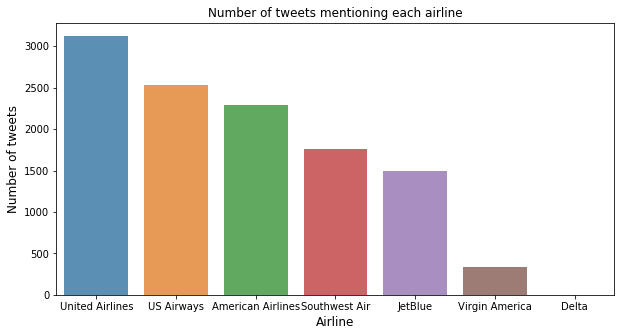

In [276]:
airline_count  = clean_airline_tweets_df['airline'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(airline_count.index, airline_count.values, alpha=0.8)
plt.title('Number of tweets mentioning each airline')
plt.ylabel('Number of tweets', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.show()

### Discussion
As the above figure shows the United Airlines has been the subject of more that 3000 tweets, whereas the Delta Airlines was only mentioned 2 times.

## 2.2. Word cloud for negative and positive airline tweets, respectively

In [277]:
negative_airline_tweets_df = clean_airline_tweets_df[(clean_airline_tweets_df['sentiment']=='negative') & (clean_airline_tweets_df['airline']!='Delta')]
positive_airline_tweets_df = clean_airline_tweets_df[(clean_airline_tweets_df['sentiment']=='positive') & (clean_airline_tweets_df['airline']!='Delta')]

In [278]:
from wordcloud import WordCloud

negative_text = []
positive_text = []

for t in negative_airline_tweets_df.cleaned_text:
    negative_text.append(t)
negative_text = pd.Series(negative_text).str.cat(sep=' ')

for t in positive_airline_tweets_df.cleaned_text:
    positive_text.append(t)
positive_text = pd.Series(positive_text).str.cat(sep=' ')


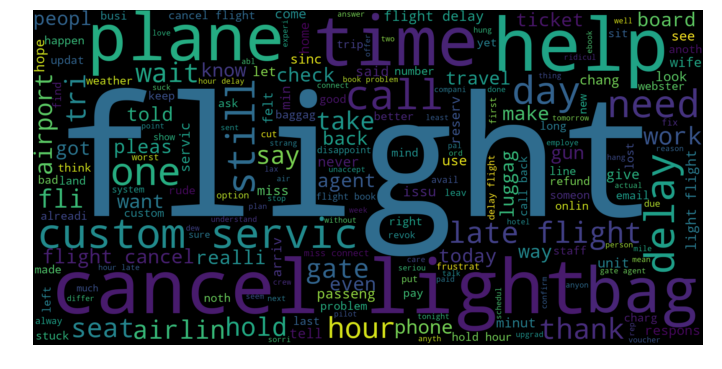

In [279]:
wordcloud_airline_negative = WordCloud(width=1600, height=800,max_font_size=400).generate(negative_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_airline_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

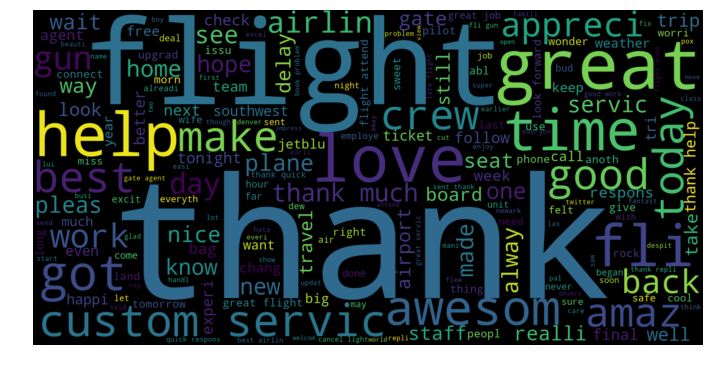

In [280]:
wordcloud_airline_positive = WordCloud(width=1600, height=800,max_font_size=400).generate(positive_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_airline_positive, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.3. (BONUS) - Identifying the most frequent words in negative an positive airline tweets

In [281]:
from sklearn.feature_extraction.text import CountVectorizer

my_df =clean_airline_tweets_df
my_df = my_df.dropna(subset=['cleaned_text'])
cvec_airline = CountVectorizer()
cvec_airline.fit(my_df.cleaned_text)

all_tweet_matrix = cvec_airline.transform(my_df.cleaned_text)
neg_tweet_matrix = cvec_airline.transform(my_df[my_df.sentiment == 'negative'].cleaned_text)
pos_tweet_matrix = cvec_airline.transform(my_df[my_df.sentiment == 'positive'].cleaned_text)
neg_tf = np.sum(neg_tweet_matrix,axis=0)/len(my_df[my_df.sentiment == 'negative'])
pos_tf = np.sum(pos_tweet_matrix,axis=0)/len(my_df[my_df.sentiment == 'positive'])
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_airline_df = pd.DataFrame([neg,pos],columns=cvec_airline.get_feature_names()).transpose()
term_freq_airline_df.head()

,0,1
aaaand,0.000109,0.000000
aaron,0.000000,0.000426
aback,0.000109,0.000000
abandon,0.000437,0.000000
abassinet,0.000000,0.000426


In [282]:
term_freq_airline_df.columns = ['negative', 'positive']
term_freq_airline_df['total'] = term_freq_airline_df['negative'] + term_freq_airline_df['positive']
most_repeated_words_airline_df=term_freq_airline_df.sort_values(by='total', ascending=False).iloc[:10]
most_repeated_words_airline_df

,negative,positive,total
flight,0.390920,0.196170,0.587090
thank,0.043545,0.455745,0.499289
get,0.131507,0.065106,0.196614
servic,0.084361,0.069362,0.153723
help,0.080650,0.066809,0.147459
custom,0.085452,0.052340,0.137793
time,0.084034,0.048936,0.132970
hour,0.121576,0.009362,0.130938
delay,0.099312,0.020000,0.119312
cancel,0.100404,0.015745,0.116148


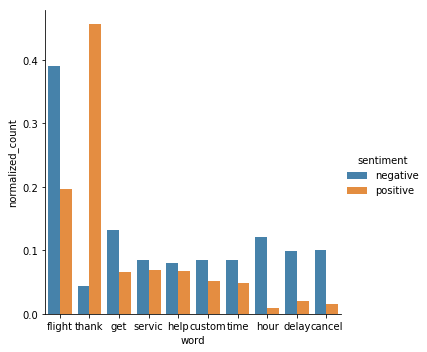

In [283]:
most_repeated_words_airline_df['word'] = most_repeated_words_airline_df.index
df2 = pd.melt(most_repeated_words_airline_df[['word','negative','positive']], id_vars='word', var_name="sentiment", value_name="normalized_count")
sns.catplot(x='word', y='normalized_count', hue='sentiment', data=df2, kind='bar', alpha=0.9)

### Discussion
The above figure and table show top 10 frequent words in US airline tweets. As obvious, the word "flight" is the most frequently used word. The interesting thing is that the word "thank", which is on the 2nd rank, has been used in positive tweets significantly more that negative tweets. On the other hand, the word "delay" has the 9th most frequent word, has been used more in negative tweets than positive ones.

## 2.4. The quantity of sentiments in generic tweets

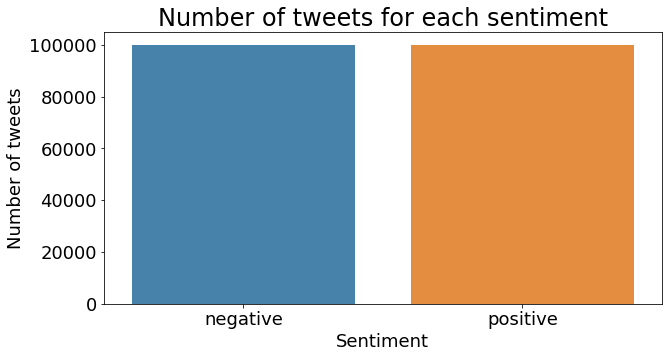

In [284]:
tweets_count  = clean_generic_tweets_df['sentiment'].value_counts()
plt.figure(figsize=(10,5))
g=sns.barplot(['negative', 'positive'], tweets_count.values, alpha=0.9)
plt.title('Number of tweets for each sentiment', fontsize=24)
plt.ylabel('Number of tweets', fontsize=18)
plt.xlabel('Sentiment', fontsize=18)
g.tick_params(labelsize=18)
plt.show()

### Discussion
50% of the data is with negative label, and another 50% with positive label.
We can see there’s no skewness on the class division.

## 2.5. Word cloud on negative and positive generic tweets, respectively


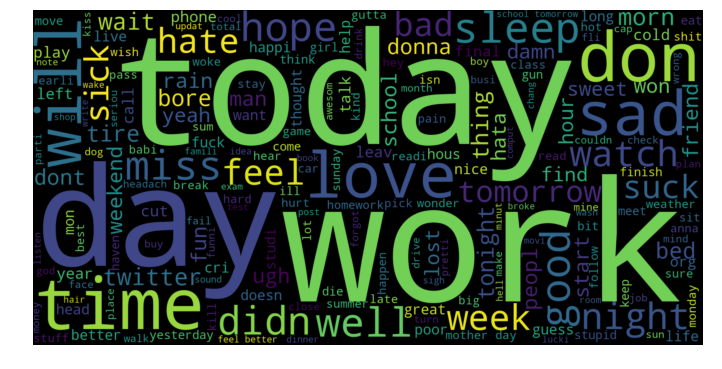

In [17]:
neg_tweets_text=[]
for t in clean_generic_tweets_df[clean_generic_tweets_df['sentiment']==0].cleaned_text:
    neg_tweets_text.append(t)
neg_tweets_text = pd.Series(neg_tweets_text).str.cat(sep=' ')

neg_tweets_wordCloud = WordCloud(width=1600, height=800,max_font_size=400).generate(neg_tweets_text)
plt.figure(figsize=(12,10))
plt.imshow(neg_tweets_wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

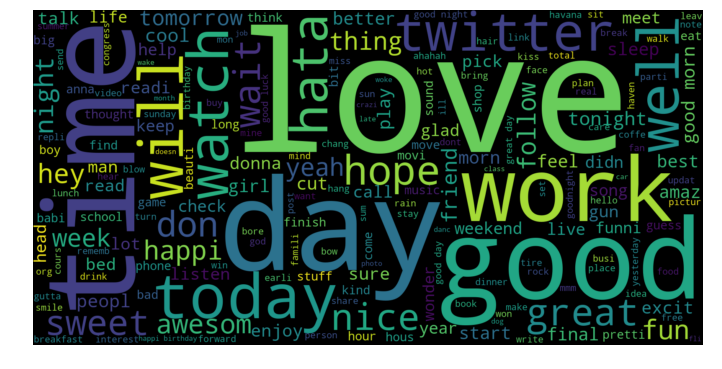

In [14]:
pos_tweets_text=[]
for t in clean_generic_tweets_df[clean_generic_tweets_df['sentiment']==4].cleaned_text:
    pos_tweets_text.append(t)
pos_tweets_text = pd.Series(pos_tweets_text).str.cat(sep=' ')

pos_tweets_wordCloud = WordCloud(width=1600, height=800,max_font_size=400).generate(pos_tweets_text)
plt.figure(figsize=(12,10))
plt.imshow(pos_tweets_wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.6. (BONUS) - Hourly distribution of generic tweets

In [285]:
hour_list = []
for i in range(0, len(clean_generic_tweets_df)):
    hour_list.append(int(clean_generic_tweets_df['date'][i][11:13]))
    
data = {'hour': hour_list, 'sentiment': clean_generic_tweets_df['sentiment']}
hourly_generic_tweets_df = pd.DataFrame(data=data)

hourly_negative = hourly_generic_tweets_df[hourly_generic_tweets_df['sentiment']==0]['hour'].value_counts()
hourly_postive = hourly_generic_tweets_df[hourly_generic_tweets_df['sentiment']==4]['hour'].value_counts()

total_count = sum(hourly_negative.values) + sum(hourly_postive.values)
data1 = {'hour': hourly_negative.index, 'negative': 100*hourly_negative.values/total_count, 'positive': 100*hourly_postive.values/total_count}
hourly_count_df = pd.DataFrame(data=data1)
hourly_count_df.head()


,hour,negative,positive
0,23,4.0115,4.0300
1,0,3.7130,3.7295
2,1,3.6115,3.4745
3,3,3.5605,3.4660
4,2,3.5535,3.4560


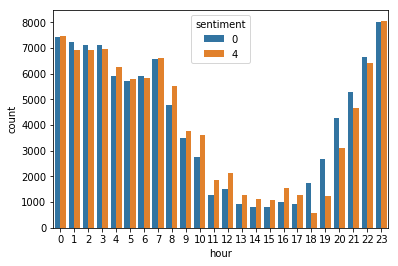

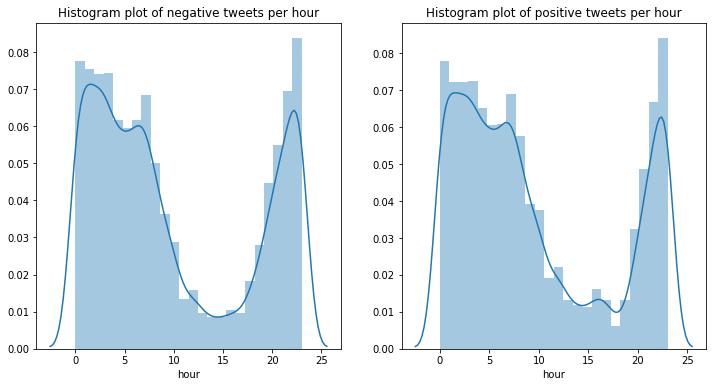

In [286]:
ax = sns.countplot(x="hour", hue="sentiment", data=hourly_generic_tweets_df)

plt.figure(2,figsize=(12, 6))
plt.subplot(121)
plt.title('Histogram plot of negative tweets per hour')
sns.distplot(hourly_generic_tweets_df[hourly_generic_tweets_df['sentiment']==0]['hour'], bins=24)
plt.subplot(122)
plt.title('Histogram plot of positive tweets per hour')
sns.distplot(hourly_generic_tweets_df[hourly_generic_tweets_df['sentiment']==4]['hour'], bins=24)


### Discussion
As it is obvious from the above figures, the distribution of positive and negative tweets during the day is different. The interesting point is that during day time, i.e., from 8 to 18, the frequency of positive tweets are more. However, during evening time, i.e., 18 to 23, the negative tweets are more frequent. During the night time, i.e., 23 to 8, both negative and positive tweets are similarly frequent. 

## 2.7. (BONUS) - Most frequent words sentiment analysis

In [287]:
my_df =clean_generic_tweets_df
my_df = my_df.dropna(subset=['cleaned_text'])
cvec_generic = CountVectorizer()
cvec_generic.fit(my_df.cleaned_text)

neg_tweet_matrix = cvec_generic.transform(my_df[my_df.sentiment == 0].cleaned_text)
pos_tweet_matrix = cvec_generic.transform(my_df[my_df.sentiment == 4].cleaned_text)
neg_tf = np.sum(neg_tweet_matrix,axis=0)
pos_tf = np.sum(pos_tweet_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec_generic.get_feature_names()).transpose()
term_freq_df.head()

,0,1
aaaaa,5,1
aaaaaa,0,1
aaaaaaaa,2,0
aaaaaaaaaa,1,1
aaaaaaaaaaaaaaaaaaaaah,0,1


In [288]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
most_repeated_words_df=term_freq_df.sort_values(by='total', ascending=False).iloc[:10]
most_repeated_words_df

,negative,positive,total
day,7550,7039,14589
good,3907,8307,12214
work,8387,3800,12187
love,2842,7667,10509
today,5099,3926,9025
time,4221,4421,8642
feel,4699,1895,6594
will,2809,3727,6536
night,3086,3443,6529
don,3962,2259,6221


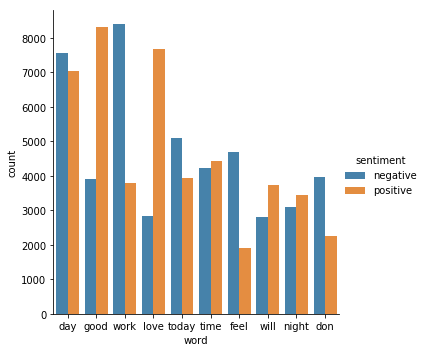

In [289]:
most_repeated_words_df['word'] = most_repeated_words_df.index
df2 = pd.melt(most_repeated_words_df[['word','negative','positive']], id_vars='word', var_name="sentiment", value_name="count")
sns.catplot(x='word', y='count', hue='sentiment', data=df2, kind='bar', alpha=0.9)

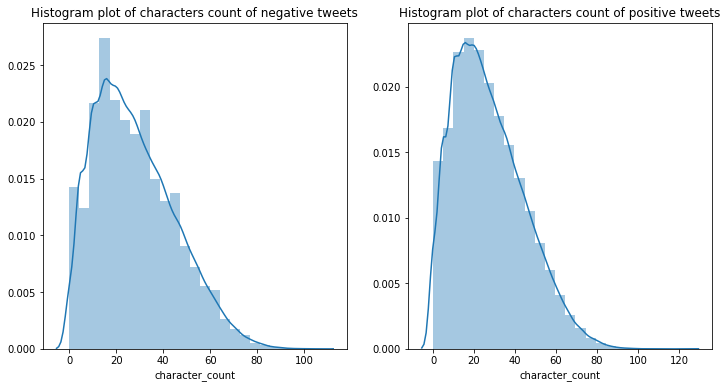

In [290]:
plt.figure(2,figsize=(12, 6))
plt.subplot(121)
plt.title('Histogram plot of characters count of negative tweets')
sns.distplot(clean_generic_tweets_df[clean_generic_tweets_df['sentiment']==0]['character_count'], bins=25)
plt.subplot(122)
plt.title('Histogram plot of characters count of positive tweets')
sns.distplot(clean_generic_tweets_df[clean_generic_tweets_df['sentiment']==4]['character_count'], bins=25)

### Discussion
The above figure and table show top 10 frequent words in generic tweets. As obvious, the word "day" is the most frequently used word. The interesting thing is that the words "good" and 'love', which are on the 2nd and 3rd ranks, has been used in positive tweets significantly more that negative tweets. On the other hand, the words "work" and 'feel have been used more in negative tweets than positive ones.

# 3. Model Preparation

In [291]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve

## 3.1. Handle the NaN values
Let's look at all the cleaned tweets that have NaN text values in the Pandas dataframe.

In [292]:
clean_generic_tweets_df[clean_generic_tweets_df['cleaned_text'].isnull()]

,cleaned_text,date,sentiment,character_count
83,NaN,Mon Apr 06 22:25:54 PDT 2009,0,0
175,NaN,Mon Apr 06 22:31:48 PDT 2009,0,0
191,NaN,Mon Apr 06 22:32:31 PDT 2009,0,0
196,NaN,Mon Apr 06 22:32:50 PDT 2009,0,0
208,NaN,Mon Apr 06 22:33:25 PDT 2009,0,0
249,NaN,Mon Apr 06 22:36:27 PDT 2009,0,0
282,NaN,Mon Apr 06 22:38:20 PDT 2009,0,0
308,NaN,Mon Apr 06 22:41:16 PDT 2009,0,0
356,NaN,Mon Apr 06 22:43:29 PDT 2009,0,0
398,NaN,Mon Apr 06 22:46:53 PDT 2009,0,0


### Replace the NaN valued texts with an empty string 

In [293]:
clean_generic_tweets_noNAN_df = clean_generic_tweets_df.set_value(clean_generic_tweets_df['cleaned_text'].isnull(), 'cleaned_text','')
clean_generic_tweets_noNAN_df[clean_generic_tweets_noNAN_df['cleaned_text'].isnull()]

,cleaned_text,date,sentiment,character_count


## 3.2. Split the generic tweets randomly into training data (70%) and test data (30%).

In [294]:
X_generic_train, X_generic_test, y_generic_train, y_generic_test  = train_test_split(clean_generic_tweets_noNAN_df['cleaned_text'], clean_generic_tweets_noNAN_df['sentiment'], random_state=42, test_size=0.3)

## 3.3. Input for machine learning algorithms for classifications
Here, the term frequency of each word was selected as the features of the model. The scikit learn count vectorizer package is imported. This module computes the frequncy of each word (unigram token) as the features.


In [295]:
generic_vectorizer = CountVectorizer()
X_generic_train_feature = generic_vectorizer.fit_transform(X_generic_train)
X_generic_test_feature = generic_vectorizer.transform(X_generic_test)

BagofWords_generic= generic_vectorizer.get_feature_names()
generic_feature_list = list(BagofWords_generic)
print(generic_feature_list)

['aaaaa', 'aaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaaggggggggghhhhhhhh', 'aaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaaaaaaaahhhh', 'aaaaaaaaaaaag', 'aaaaaaaaaaaah', 'aaaaaaaaaaah', 'aaaaaaaaaah', 'aaaaaaaaaahhhhhhhhhhh', 'aaaaaaaaand', 'aaaaaaaaao', 'aaaaaaaah', 'aaaaaaahahahahahaha', 'aaaaaaahhh', 'aaaaaaand', 'aaaaaah', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhh', 'aaaaaall', 'aaaaaalllat', 'aaaaaand', 'aaaaaarrrrrrrrr', 'aaaaaaw', 'aaaaahhhh', 'aaaaallll', 'aaaaamaz', 'aaaaand', 'aaaaannnnd', 'aaaaargh', 'aaaaarrgh', 'aaaaaw', 'aaaaawwwwwww', 'aaaacheee', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaallwaaaay', 'aaaami', 'aaaand', 'aaaannd', 'aaaannnddyyi', 'aaaargh', 'aaaarrrrrggggghhhh', 'aaaawesom', 'aaaaww', 'aaaawww', 'aaaawwwwwwwww', 'aaafyh', 'aaahhhh', 'aaahhhhhh', 'aaahhmazzzz', 'aaallll', 'aaammaaaz', 'aaaoouuwww', 'aaargh', 'aaarghhh', 'aaarrgghh', 'aaarrgghhhhhh', 'aaarrrggg', 'aaarrrgggh', 'a

There are some non zero values in the bag of words, the sparse format of the data frame is provided below.

In [296]:
print(X_generic_train_feature)

  (0, 14607)	1
  (0, 20642)	1
  (0, 12310)	1
  (1, 18164)	1
  (1, 6960)	1
  (1, 19656)	1
  (2, 5046)	1
  (2, 17605)	1
  (3, 9608)	1
  (4, 18490)	1
  (4, 4576)	1
  (4, 6045)	1
  (5, 2619)	1
  (5, 15740)	1
  (5, 9461)	1
  (5, 6876)	1
  (5, 12369)	1
  (5, 9762)	1
  (5, 21716)	1
  (5, 18316)	1
  (6, 15294)	1
  (6, 6752)	1
  (6, 3404)	1
  (7, 8142)	1
  (7, 8406)	1
  :	:
  (139994, 4183)	1
  (139994, 8306)	1
  (139995, 20695)	1
  (139995, 7485)	1
  (139995, 20664)	1
  (139995, 22987)	1
  (139996, 16212)	1
  (139996, 23030)	1
  (139997, 4800)	1
  (139997, 10454)	1
  (139997, 16450)	1
  (139997, 15420)	1
  (139997, 20452)	1
  (139997, 12031)	1
  (139998, 18877)	1
  (139998, 8512)	1
  (139998, 22513)	1
  (139999, 21876)	1
  (139999, 6287)	1
  (139999, 13832)	1
  (139999, 11548)	1
  (139999, 8245)	1
  (139999, 19429)	1
  (139999, 22657)	1
  (139999, 13955)	1


# 4. Model Implementation + Results
## 4.1. Creating the model based on 70% of generic tweets and validate it on the remaining 30% of generic tweets
In our first model, we use the default input parameters for the logisitc regression.

In [297]:
model = LogisticRegression()    
model.fit(X_generic_train_feature, y_generic_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Apply the model to the test data to obtain an accuracy value + Results

In [298]:
predictions = model.predict(X_generic_test_feature)
    
TN = confusion_matrix(y_generic_test, predictions)[0][0]
FP = confusion_matrix(y_generic_test, predictions)[0][1]
FN = confusion_matrix(y_generic_test, predictions)[1][0]
TP = confusion_matrix(y_generic_test, predictions)[1][1]
total = TN + FP + FN + TP

precision = TP/float(TP+FP)
recall = TP/float(TP+FN)
accuracy = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,2))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,2))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,2))) 

This model got an accuracy of 72.59% on the testing set
This model got a precision of 71.18% on the testing set
This model got a recall of 76.37% on the testing set


### Discussion
As the accuracy score of our model shows, the model is not satisfactory, which means that the model does not properly predict the sentiment of tweets. There are a few reasons causing this problem, which will be discussed in the **5. Other Results** section of this report. One way to **improve** the model accuracy is to identify the optimal input parameters of the logistic regression model to achieve the highest possible accuracy level. This is done in section **4.5. Optimize model**. 

## 4.2. (BONUS) - Cross validation using K-fold + Results

KFold Cross Validation is a common method where the training set is split into k equal sizes. Then of the k subsamples, a single sample is used for testing, and the remaining k-1 samples are used for training. This process continues k times, and each time a different sample is used for testing. This results in each sample being tested once. At the end of this we get 10 accuracies for the model and, from this, we can get the average accuracy, and the standard deviation of the accuracy. The higher the average accuracy, the lower the bias. The lower the standard deviation, the lower the variance. This better represents the true performance of the model on the training set.

In [42]:
X = clean_generic_tweets_noNAN_df['cleaned_text']
y = clean_generic_tweets_noNAN_df['sentiment'] 

model = LogisticRegression()
cvec = CountVectorizer()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0


for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = cvec.fit_transform(X_train)
    X_test = cvec.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

C:\Users\hossein89\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1: Accuracy: 0.6%
Fold 2: Accuracy: 0.624%
Fold 3: Accuracy: 0.606%
Fold 4: Accuracy: 0.631%
Fold 5: Accuracy: 0.618%
Fold 6: Accuracy: 0.692%
Fold 7: Accuracy: 0.711%
Fold 8: Accuracy: 0.68%
Fold 9: Accuracy: 0.696%
Fold 10: Accuracy: 0.691%
Average Score: 65.48%(4.068%)


### Discussion
The average accuracy score computed using the cross validation method is quite less than the accuracy score computed using the random split of data. This might stem from the fact that a random realization of training and test datasets can lead to high or low accuracy scores. However, through the cross validation. this randomness is reduced to some extent and hence, the average accuracy score is more reliable.

## 4.3. (BONUS) - Learning curve of the trained model + Results
Plot the mean accuracy, the "learning curve", of the classifier on both the training and validation dataset.

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<module 'matplotlib.pyplot' from 'F:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

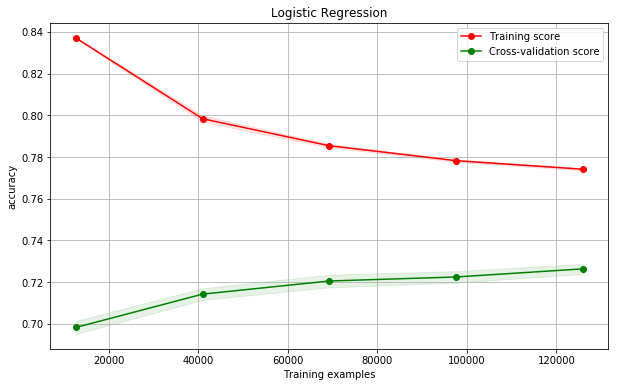

In [56]:
plot_learning_curve(model,'Logistic Regression', feature_generic_train_vec, y_generic_train, cv=10)

### Discussion
As seen from the above figure, the accuracy scores of the trainig and validation data are quite different. However, as more data are used, the scores converge. 

## 4.4. (BONUS) - Optimize the model: Grid Search + Results

Grid searching is a well known method for selecting hyperparameters that optimize your model.

Grid search just builds several models with all the parameter combinations specified, and runs cross validation to return the set of parameters that had the highest cv score on the validation set.
Here, the goal is to find the optimal input parameters the logisitc regression model in order to achieve the highest accuracy level

In [43]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [45]:
X = clean_generic_tweets_noNAN_df['cleaned_text']
y = clean_generic_tweets_noNAN_df['sentiment']

cvec = CountVectorizer()
model = LogisticRegression()
# scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = cvec.fit_transform(X_train)
            X_test = cvec.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 100, 'solver': 'sag'}
Best Score: 65.613%(3.597%)

The optimal log model uses C=100, and a sag solver, and has a cross validation score of 65.613% with a standard deviation of 3.597%


### Discussion
As obtained from the grid search function the optimal configuration of the logistic regression model is C=1 and solver=sag. In result, the average accuracy score is improved. However, the improvement is not that significant.

## 4.5. Create and  train the logistic regression model on the entire training data set
Once the optimal configuration of logistic regression model is obtained, the model is created using the entire set of training data, i.e., the 200,000 generic tweets

In [299]:
generic_entire_vectorizer = CountVectorizer()
X_generic_entire_train = generic_entire_vectorizer.fit_transform(clean_generic_tweets_noNAN_df['cleaned_text'])
y_generic_entire_train = clean_generic_tweets_noNAN_df['sentiment']
BagOfWords_generic_entire= generic_entire_vectorizer.get_feature_names()

model_entire = LogisticRegression(C=100, solver= 'sag') 
model_entire.fit(X_generic_entire_train, y_generic_entire_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

## 4.5. Evaluate the trained logistic regression on the airline tweets + Results
### 4.5.1. Handle the NaN values of airline tweets
Let's look at all the cleaned airline tweets that have NaN text values in the Pandas dataframe.

In [300]:
clean_airline_tweets_df[clean_airline_tweets_df['cleaned_text'].isnull()]

,cleaned_text,airline,sentiment,negative_reason,retweet_count
472,NaN,United Airlines,positive,NaN,0
549,NaN,United Airlines,positive,NaN,0
799,NaN,United Airlines,positive,NaN,0
1278,NaN,United Airlines,negative,Cancelled Flight,0
1674,NaN,United Airlines,negative,Bad Flight,0
2085,NaN,United Airlines,negative,Late Flight,0
2372,NaN,United Airlines,positive,NaN,0
2430,NaN,United Airlines,positive,NaN,0
2509,NaN,United Airlines,positive,NaN,0
2882,NaN,United Airlines,negative,Lost Luggage,0


In [301]:
clean_airline_tweets_noNAN_df = clean_airline_tweets_df.set_value(clean_airline_tweets_df['cleaned_text'].isnull(), 'cleaned_text','')
clean_airline_tweets_noNAN_df[clean_airline_tweets_noNAN_df['cleaned_text'].isnull()]

,cleaned_text,airline,sentiment,negative_reason,retweet_count


### 4.5.2. Input for machine learning algorithms for classifications

In [302]:
clean_airline_tweets_noNAN_df['sentiment'] = clean_airline_tweets_noNAN_df['sentiment'].map({'positive': 4, 'negative': 0})
clean_airline_tweets_noNAN_df.tail()

,cleaned_text,airline,sentiment,negative_reason,retweet_count
11536,flight cancel light leav tomorrow morn auto re...,American Airlines,0,Cancelled Flight,0
11537,right due delay,American Airlines,0,Late Flight,0
11538,thank got differ flight chicago,American Airlines,4,NaN,0
11539,leav minut late flight warn commun minut late ...,American Airlines,0,Customer Service Issue,0
11540,money chang flight answer phone suggest make c...,American Airlines,0,Customer Service Issue,0


In [303]:
feature_airline_count_vec = generic_entire_vectorizer.transform(clean_airline_tweets_noNAN_df['cleaned_text'])
airline_sentiment_test = clean_airline_tweets_noNAN_df['sentiment']

BagOfWords_airline_df = pd.DataFrame(feature_airline_count_vec.toarray())
BagOfWords_airline_df.columns= BagOfWords_generic_entire
# airline_feature_list = list(BagOfWords_airline_df.columns)
# # print(airline_feature_list)
BagOfWords_airline_df.tail()

,aaaaa,aaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaah,aaaaaaaaaaaaaaaaaaaaahhhhh,aaaaaaaaaaaaaaaaaaaah,aaaaaaaaaaaaaaaaaahhhhh,aaaaaaaaaaaaaaaaggggggggghhhhhhhh,aaaaaaaaaaaaaaah,...,zzzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
11536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.5.3. Calculate the accuracy rate of the created model on the airline tweets + Results

In [304]:
predictions_sentiment = model_entire.predict(feature_airline_count_vec)
# print(predictions)
# print(airline_sentiment_test)

TN = confusion_matrix(airline_sentiment_test, predictions_sentiment)[0][0]
FP = confusion_matrix(airline_sentiment_test, predictions_sentiment)[0][1]
FN = confusion_matrix(airline_sentiment_test, predictions_sentiment)[1][0]
TP = confusion_matrix(airline_sentiment_test, predictions_sentiment)[1][1]
total = TN + FP + FN + TP

precision = TP/float(TP+FP)
recall = TP/float(TP+FN)
accuracy = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,2))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,2))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,2))) 

This model got an accuracy of 72.87% on the testing set
This model got a precision of 41.63% on the testing set
This model got a recall of 80.87% on the testing set


### Discussion
As the accuracy score of our model shows, the model is not satisfactory, which means that the model does not properly predict the sentiment of tweets. There are a few reasons causing this problem, which will be discussed in the **5. Other Results** section of this report. One way to **improve** the model accuracy is to identify the optimal input parameters of the logistic regression model to achieve the highest possible accuracy level. This was done in section **4.5. Optimize model**. 

## 4.6. Find the most important negative and positive features + Results
Now, we are going to find the highest contributing features to determine the sentiment of a text. The features with highest coefficient are those that contributes the most to identify the sentiment of the tweets.

In [305]:
feature_coef_df = pd.DataFrame(columns = ['feature','coefficient'])
feature_coef_df['coefficient'] = model_entire.coef_[0]
feature_coef_df['feature'] = BagOfWords_generic_entire
feature_coef_df[1000:1005]

,feature,coefficient
1000,anoint,-0.061184
1001,anon,-0.261155
1002,anonym,-0.351714
1003,anorex,-0.469812
1004,anorexia,0.344888


In [306]:
negative_features = feature_coef_df.sort_values(['coefficient'], ascending=True).iloc[:10]
positive_features = feature_coef_df.sort_values(['coefficient'], ascending=False).iloc[:10]

In [307]:
negative_features

,feature,coefficient
20810,sadden,-4.117297
3071,booooo,-3.902317
24925,toothach,-3.655091
11414,homesick,-3.412728
5145,conceal,-3.364796
20816,sadli,-3.359599
5171,condol,-3.328255
5558,cramp,-3.294516
27470,woe,-3.179457
8967,fractur,-3.130801


In [308]:
positive_features

,feature,coefficient
27680,worthwhil,3.146503
7655,entail,3.040011
20876,salut,2.853268
4115,cashback,2.781357
19170,preserv,2.693804
27933,yayyy,2.660329
23624,sunroof,2.656495
7428,elabor,2.652864
5120,compliment,2.650635
9463,garfield,2.632550


### Discussion
The two above tables show the top 10 features with highest negative and positive model coefficients. The words completely make sense as all all of the negative and positive words have negative and positive meanings, respectively. For instance, the words 'congratul', 'compliment', and 'worthwhil' are positive, and the words 'sadli', 'sad', and 'sadden' are negative, which all are in consistent with our perception.

##  4.7. (BONUS) - Use other classification methods to predict the sentiment + Results

In [309]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [36]:
Classifiers = [
    LogisticRegression(C=1,solver='newton-cg'),
    KNeighborsClassifier(3),
#     SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
#     RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier()]

In [37]:
Accuracy=[]
Model=[]

for classifier in Classifiers:
    fit = classifier.fit(X_generic_entire_train,y_generic_entire_train)
    pred = fit.predict(feature_airline_count_vec)
    accuracy = accuracy_score(pred,airline_sentiment_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy)) 

Accuracy of LogisticRegression is 0.7302660081448747
Accuracy of KNeighborsClassifier is 0.7785287236807902
Accuracy of DecisionTreeClassifier is 0.6707391040637727
Accuracy of AdaBoostClassifier is 0.334113161771077


Text(0.5, 1.0, 'Accuracies of Models')

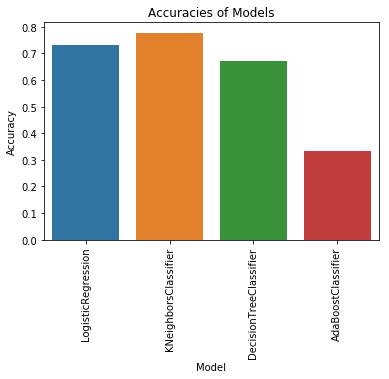

In [38]:
Index = [0,1,2,3]
sns.barplot(Index,Accuracy)
plt.xticks(Index, Model,rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

### Discussion
As seen from the above figure the classifier which yields the highest accuracy score (78%) is the k-nearest neighbors classifier. On the other end, the Adaptive Boost classifier gives the lowest accuracy score (33%). 

## 4.8. Multi-class logistic regression model to predict the reason for the negative tweets
### 4.8.1. Handle the NaN values of airline tweets

In [310]:
negative_airline_tweets_noNAN_df = negative_airline_tweets_df.set_value(negative_airline_tweets_df['cleaned_text'].isnull(), 'cleaned_text','')
negative_airline_tweets_noNAN_df = negative_airline_tweets_noNAN_df.drop(['retweet_count'] , axis=1)
negative_airline_tweets_noNAN_df[negative_airline_tweets_noNAN_df['cleaned_text'].isnull()]

,cleaned_text,airline,sentiment,negative_reason


### 4.8.2. Combine similar reasons into fewer categories
There are 10 different categories of negative reasons in the US airline tweets. Some of these reasons have some similarities and can be grouped in one category. Based on the reasons, the grouping scheme is as follows:
- **Luggage Issues**: Lost Luggage, Damaged Luggage
- **Service Issues**: Flight Booking Problems, longlines, Customer Service Issue, Flight Attendant Complaints
- **Flight Issues**: Cancelled Flight, Late Flight, Bad Flight
- **Can't Tell**: Can't Tell

If we group the reasons into fewer categories, we lose some information, yet, as shown later, we gain higher accuracy score. To prove that, two classification models are created: one with 10 classes of negative reasons, and one with only 4 classes.

In [311]:
negative_reasons_dict={'Lost Luggage': 0, 'Damaged Luggage': 1, 'Flight Booking Problems':2, 'longlines':3, 'Customer Service Issue': 4,'Flight Attendant Complaints':5, 'Cancelled Flight':6, 'Late Flight':7, 'Bad Flight':8,"Can't Tell":9}
negative_reasons_grouped_dict={'Lost Luggage': 0, 'Damaged Luggage': 0, 'Flight Booking Problems':1, 'longlines':1, 'Customer Service Issue': 1,'Flight Attendant Complaints':1, 'Cancelled Flight':2, 'Late Flight':2, 'Bad Flight':2,"Can't Tell":3}

In [312]:
# negative_airline_tweets_noNAN_df['neg_reason_num'] = negative_airline_tweets_noNAN_df['negative_reason'].map({'Lost Luggage': 0, 'Damaged Luggage': 1, 'Flight Booking Problems':2, 'longlines':3, 'Customer Service Issue': 4,'Flight Attendant Complaints':5, 'Cancelled Flight':6, 'Late Flight':7, 'Bad Flight':8,"Can't Tell":9})
# negative_airline_tweets_noNAN_df['neg_reason_num_grouped'] = negative_airline_tweets_noNAN_df['negative_reason'].map({'Lost Luggage': 0, 'Damaged Luggage': 0, 'Flight Booking Problems':1, 'longlines':1, 'Customer Service Issue': 1,'Flight Attendant Complaints':1, 'Cancelled Flight':2, 'Late Flight':2, 'Bad Flight':2,"Can't Tell":3})
negative_airline_tweets_noNAN_df['neg_reason_num'] = negative_airline_tweets_noNAN_df['negative_reason'].map(negative_reasons_dict)
negative_airline_tweets_noNAN_df['neg_reason_num_grouped'] = negative_airline_tweets_noNAN_df['negative_reason'].map(negative_reasons_grouped_dict)
negative_airline_tweets_noNAN_df.tail()

,cleaned_text,airline,sentiment,negative_reason,neg_reason_num,neg_reason_num_grouped
11535,noth get countri back broken plane come get an...,American Airlines,negative,Bad Flight,8,2
11536,flight cancel light leav tomorrow morn auto re...,American Airlines,negative,Cancelled Flight,6,2
11537,right due delay,American Airlines,negative,Late Flight,7,2
11539,leav minut late flight warn commun minut late ...,American Airlines,negative,Customer Service Issue,4,1
11540,money chang flight answer phone suggest make c...,American Airlines,negative,Customer Service Issue,4,1


### 4.8.3. Split the negative airline tweets randomly into training data (70%) and test data (30%).

In [337]:
X_negative_airline_train, X_negative_airline_test, y_negative_airline_train, y_negative_airline_test, y_negative_airline_grouped_train,y_negative_airline_grouped_test  = train_test_split(negative_airline_tweets_noNAN_df['cleaned_text'], negative_airline_tweets_noNAN_df['neg_reason_num'], negative_airline_tweets_noNAN_df['neg_reason_num_grouped'], random_state=42, test_size=0.3)


### 4.8.4. Input for machine learning algorithms for classifications
Here, the term frequency of each word was selected as the features of the model. The scikit learn count vectorizer package is imported. This module computes the frequncy of each word (unigram token) as the features.


In [314]:
airline_vectorizer = CountVectorizer()
X_negative_airline_features_train = airline_vectorizer.fit_transform(X_negative_airline_train)
X_negative_airline_features_test = airline_vectorizer.transform(X_negative_airline_test)

BagOfWords_negative_airline_entire= airline_vectorizer.get_feature_names()

BagOfWords_negative_airline_df = pd.DataFrame(X_negative_airline_features_test.toarray())
BagOfWords_negative_airline_df.columns= BagOfWords_negative_airline_entire
BagOfWords_negative_airline_df.tail()

,aaaand,aback,abandon,abc,abe,abil,abl,aboard,abroad,absolut,...,yesterday,yet,yield,york,young,younger,yuma,zero,zip,zone
2748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.8.5. Create the model based on the 70% percent airline tweets + Results
Here, as mentioned before, two models are developed: one with 10 classes of negative reasons, and one with only 4 classes.

In [315]:
model_negative_reason = LogisticRegression(C=1, solver= 'newton-cg') 
model_negative_reason.fit(X_negative_airline_features_train, y_negative_airline_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [316]:
model_negative_reason_grouped = LogisticRegression(C=1, solver= 'newton-cg') 
model_negative_reason_grouped.fit(X_negative_airline_features_train, y_negative_airline_grouped_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [317]:
predictions = model_negative_reason.predict(X_negative_airline_features_test)
accuracy_negative_reason = accuracy_score(predictions,y_negative_airline_test)
print ("This model got an accuracy of {}% on the testing set".format(round(accuracy_negative_reason*100,2))) 

This model got an accuracy of 61.1% on the testing set


In [318]:
predictions_grouped = model_negative_reason_grouped.predict(X_negative_airline_features_test)
accuracy_negative_reason_grouped = accuracy_score(predictions_grouped,y_negative_airline_grouped_test)
print ("This model got an accuracy of {}% on the testing set".format(round(accuracy_negative_reason_grouped*100,2))) 

This model got an accuracy of 72.14% on the testing set


Text(0.5, 1.0, 'accuracy score of two classification approach (10 vs. 4 classes)')

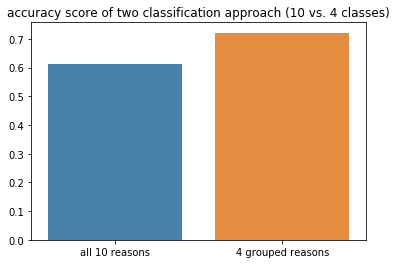

In [319]:
g=sns.barplot(['all 10 reasons','4 grouped reasons'], [accuracy_negative_reason, accuracy_negative_reason_grouped], alpha=0.9)
plt.title('accuracy score of two classification approach (10 vs. 4 classes)')

### Discussion
As seen from the above figure, if we group the negative reasons into fewer classes, the accuracy score increases significantly. However, this high accuracy score was achieved due to the sacrifice of information which can be obtained from the predictions. For instance, for the grouped classification model can only predict if there has been a flight issue, while it does not give any further information on if it has been a bad flight, cancelled flight, or late flight. In sum, the decision on what model to choose is a tradeoff between accuracy and information. 



# 5. Other Results
## 5.1. Answer the research question: “What can public opinion on Twitter tell us about the US airlines in 2015?”
Now, based on the outputs of our first model, we want to analyze the public opinion about the US airlines

In [320]:
result_airline_sentiment= pd.DataFrame()

result_airline_sentiment['airline']=clean_airline_tweets_noNAN_df['airline']
result_airline_sentiment['sentiment_observation']=clean_airline_tweets_noNAN_df['sentiment']
result_airline_sentiment['sentiment_prediction']=predictions_sentiment

result_airline_sentiment.tail()

,airline,sentiment_observation,sentiment_prediction
11536,American Airlines,0,0
11537,American Airlines,0,0
11538,American Airlines,4,4
11539,American Airlines,0,0
11540,American Airlines,0,0


### Plotting the number of tweets per each predicted sentiment

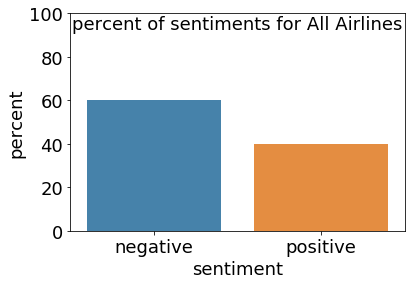

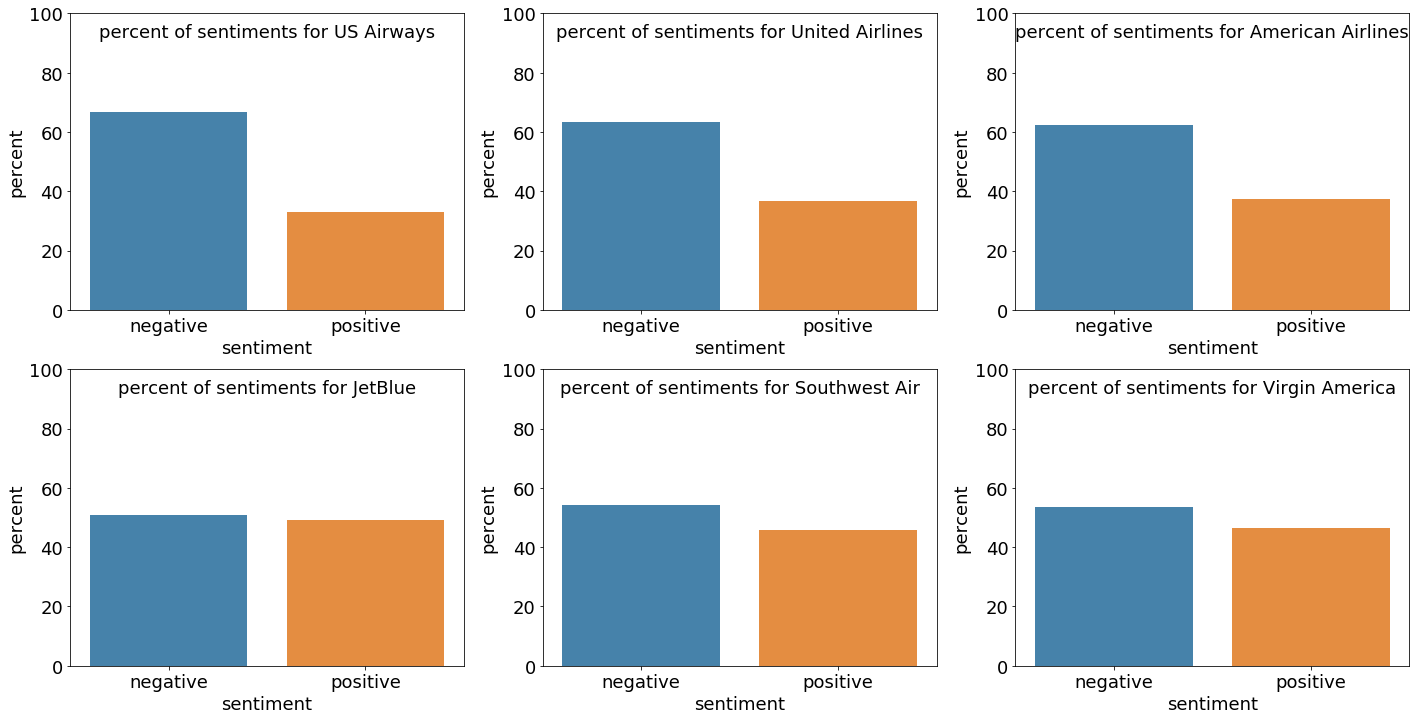

In [321]:
def plot_sub_sentiment(Airline):
    if Airline=='All Airlines':
        df=result_airline_sentiment
    else:
        df=result_airline_sentiment[result_airline_sentiment['airline']==Airline]
    
    count=df['sentiment_prediction'].value_counts()
    
#     neg_count = df['negative_reason'].value_counts()
    percent = 100* count / count.sum()
    
    g=sns.barplot(['negative','positive'], percent, alpha=0.9)
    plt.ylim(0, 100) 
    
    plt.title('percent of sentiments for '+Airline, y=0.9, fontsize=18 )
    plt.ylabel('percent', fontsize=18)
    plt.xlabel('sentiment', fontsize=18)
    g.tick_params(labelsize=18)
    
plot_sub_sentiment('All Airlines')

plt.figure(2,figsize=(24, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United Airlines')
plt.subplot(233)
plot_sub_sentiment('American Airlines')
plt.subplot(234)
plot_sub_sentiment('JetBlue')
plt.subplot(235)
plot_sub_sentiment('Southwest Air')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

### Plotting the number of tweets per each predicted sentiment, all in one figure

In [322]:
negative_count = result_airline_sentiment[result_airline_sentiment['sentiment_prediction']==0]['airline'].value_counts()
positive_count_temp = result_airline_sentiment[result_airline_sentiment['sentiment_prediction']==4]['airline'].value_counts()

positive_count = []

for i in range(0, len(negative_count)):
    airline = negative_count.index[i]
    try:
        positive_count.append(positive_count_temp[airline])
    except:
        positive_count.append(0)

negative_percent = []
positive_percent = []

for i in range(0, len(negative_count)):
    airline = negative_count.index[i]
    total_tweets_count = negative_count.values[i] + positive_count[i]
    negative_percent.append(100*negative_count.values[i]/total_tweets_count)
    positive_percent.append(100*positive_count[i]/total_tweets_count)
    
airline_sentiment_count_data = {'airline': negative_count.index, 'total': negative_count.values+positive_count, 'negative_count': negative_count.values, 'positive_count': positive_count, 'negative(%)': negative_percent,'positive(%)': positive_percent }
airline_sentiment_count_df = pd.DataFrame(data=airline_sentiment_count_data)
airline_sentiment_count_df


,airline,total,negative_count,positive_count,negative(%),positive(%)
0,United Airlines,3124,1976,1148,63.252241,36.747759
1,US Airways,2532,1694,838,66.903633,33.096367
2,American Airlines,2296,1436,860,62.543554,37.456446
3,Southwest Air,1757,955,802,54.354013,45.645987
4,JetBlue,1496,735,761,49.131016,50.868984
5,Virgin America,333,155,178,46.546547,53.453453


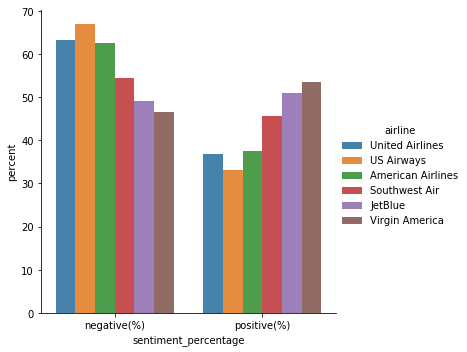

In [323]:
df1 = pd.melt(airline_sentiment_count_df[['airline','negative(%)','positive(%)']], id_vars="airline", var_name="sentiment_percentage", value_name="percent")
sns.catplot(x='sentiment_percentage', y='percent', hue='airline', data=df1, kind='bar', alpha=0.9)

### Discussion
As seen from the above figures, about **60%** of people have negative feeling about the US airlines. The US Airways has the highest rate of dissatisfaction as more **67%** of people feel negative on that. On the other hand, the Virgin America has the highest rate of consumer satisfaction. Below, the US airlines, with respect to public opinion, are provided from **Best to Worst**:
- **Virgin America**: 55% consumer satisfaction
- **JetBlue**: 52% consumer satisfaction
- **Southwest Air**: 46% consumer satisfaction
- **American  Airlines**: 37% consumer satisfaction
- **United Airlines**: 37% consumer satisfaction
- **US Airways**: 33% consumer satisfaction



## 5.2. Analyzing the negative reasons of consumer dissatisfaction
Here, based on the public opinion, we want to analyze the negative reasons of consumers dissatisfaction. Two approaches were adopted here: first, analyzing the entire set of reasons including 10 reasons, second, analyzing the grouped four classes of reasons 

In [324]:
negative_reasons_dict_rev = dict((v,k) for k,v in negative_reasons_dict.items())
negative_reasons_dict_rev_gp = { 0:'Luggage Issues', 
                                1:'Service Issues', 
                                2:'Flight Issues', 
                                3:"Can't Tell"}

### Create the dataframe which contains the predicted and observed negative reasons 

In [325]:
X_negative_airline_features_all = airline_vectorizer.transform(negative_airline_tweets_noNAN_df['cleaned_text'])

result_airline= pd.DataFrame()
result_airline['airline']=negative_airline_tweets_noNAN_df['airline']
result_airline['neg_reason_num']=negative_airline_tweets_noNAN_df['neg_reason_num']
result_airline['neg_reason_num_pred'] = model_negative_reason.predict(X_negative_airline_features_all)
result_airline['neg_reason_num_grouped']=negative_airline_tweets_noNAN_df['neg_reason_num_grouped']
result_airline['neg_reason_num_grouped_pred'] = model_negative_reason_grouped.predict(X_negative_airline_features_all)
result_airline.tail()

,airline,neg_reason_num,neg_reason_num_pred,neg_reason_num_grouped,neg_reason_num_grouped_pred
11535,American Airlines,8,8,2,2
11536,American Airlines,6,6,2,2
11537,American Airlines,7,7,2,2
11539,American Airlines,4,4,1,1
11540,American Airlines,4,4,1,1


In [326]:
result_airline_negative_reasons= pd.DataFrame()
result_airline_negative_reasons['airline']=negative_airline_tweets_noNAN_df['airline']
result_airline_negative_reasons['negative_reason_obs']=result_airline['neg_reason_num'].map(negative_reasons_dict_rev)
result_airline_negative_reasons['negative_reason_pred'] =result_airline['neg_reason_num_pred'].map(negative_reasons_dict_rev)
result_airline_negative_reasons['negative_reason_grouped_obs']=result_airline['neg_reason_num_grouped'].map(negative_reasons_dict_rev_gp)
result_airline_negative_reasons['negative_reason_grouped_pred'] = result_airline['neg_reason_num_grouped_pred'].map(negative_reasons_dict_rev_gp)
result_airline_negative_reasons.head()

,airline,negative_reason_obs,negative_reason_pred,negative_reason_grouped_obs,negative_reason_grouped_pred
1,Virgin America,Bad Flight,Bad Flight,Flight Issues,Flight Issues
2,Virgin America,Can't Tell,Can't Tell,Can't Tell,Can't Tell
3,Virgin America,Can't Tell,Bad Flight,Can't Tell,Flight Issues
11,Virgin America,Late Flight,Customer Service Issue,Flight Issues,Service Issues
13,Virgin America,Bad Flight,Bad Flight,Flight Issues,Flight Issues


### Plotting the number of tweets per each predicted negative reason

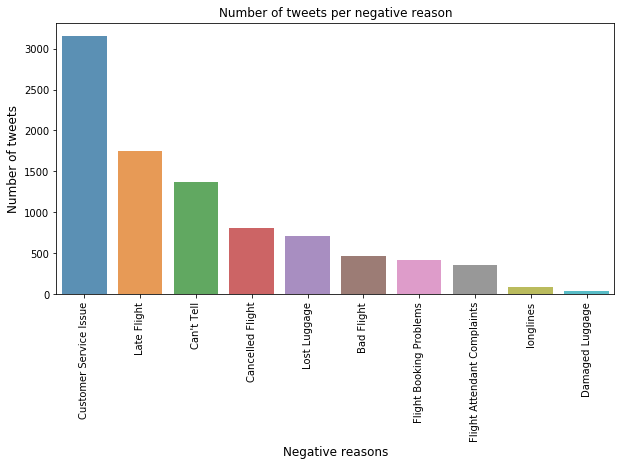

In [327]:
airline_reason_count  = result_airline_negative_reasons['negative_reason_pred'].value_counts()
plt.figure(figsize=(10,5))
g=sns.barplot(airline_reason_count.index, airline_reason_count.values, alpha=0.8)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.title('Number of tweets per negative reason')
plt.ylabel('Number of tweets', fontsize=12)
plt.xlabel('Negative reasons', fontsize=12)
plt.show()

### Plotting the number of tweets per each predicted grouped negative reason

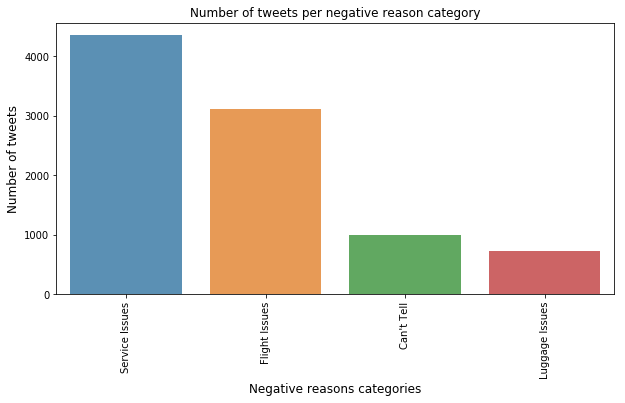

In [328]:
airline_reason_count  = result_airline_negative_reasons['negative_reason_grouped_pred'].value_counts()
plt.figure(figsize=(10,5))
g=sns.barplot(airline_reason_count.index, airline_reason_count.values, alpha=0.8)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.title('Number of tweets per negative reason category')
plt.ylabel('Number of tweets', fontsize=12)
plt.xlabel('Negative reasons categories', fontsize=12)
plt.show()

### Plotting the percent of tweets per each predicted negative reason

In [329]:
def NR_Percent(Airline, grouped=False):
    if Airline=='All Airlines':
        df=result_airline_negative_reasons
    else:
        df=result_airline_negative_reasons[result_airline_negative_reasons['airline']==Airline]
        
    if grouped:
        neg_count = df['negative_reason_grouped_pred'].value_counts()
        Unique_reason=list(result_airline_negative_reasons['negative_reason_grouped_pred'].unique())
    else:
        neg_count = df['negative_reason_pred'].value_counts()
        Unique_reason=list(result_airline_negative_reasons['negative_reason_pred'].unique())
        
    NR_percent = 100* neg_count / neg_count.sum()
    percent=dict(NR_percent)

    
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['percent']=Reason_frame['Reasons'].apply(lambda x: percent[x])
    return Reason_frame

def plot_reason(Airline,grouped=False):
    df=NR_Percent(Airline,grouped)

    count=df['percent']
    Index = range(1,(len(df)+1))
    g=sns.barplot(df['Reasons'], df['percent'], alpha=0.9)
    for item in g.get_xticklabels():
        item.set_rotation(90)
    plt.ylim(0, 60)
    plt.title('Percent of Reasons for '+Airline)
    plt.ylabel('Percent', fontsize=12)
    plt.xlabel('Negative reasons', fontsize=12)
       

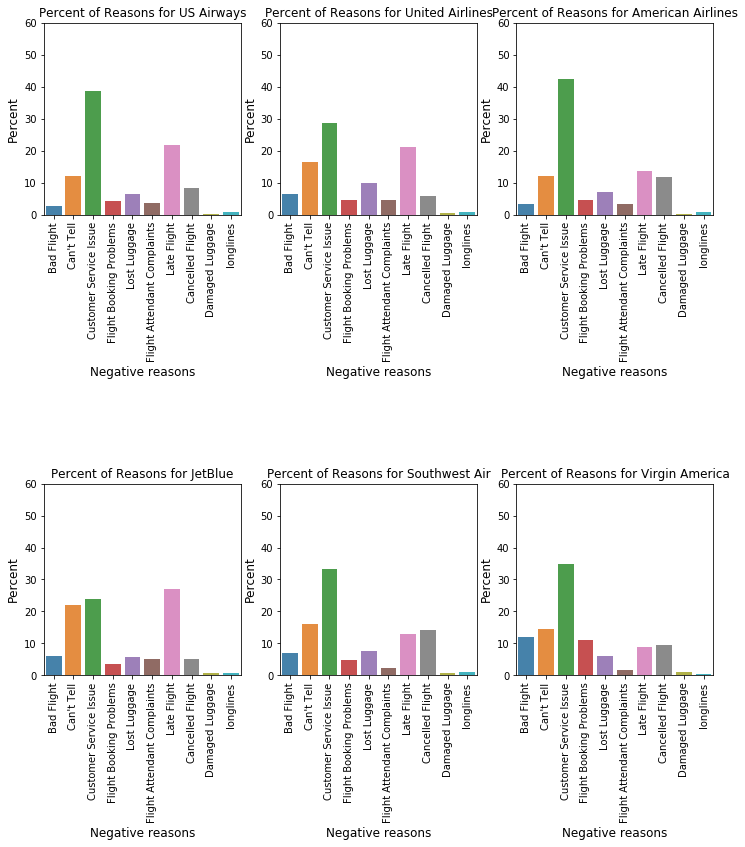

In [330]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(12, 12))

plt.subplot(331)
plot_reason('US Airways')
plt.subplot(332)
plot_reason('United Airlines')
plt.subplot(333)
plot_reason('American Airlines')
plt.subplot(337)
plot_reason('JetBlue')
plt.subplot(338)
plot_reason('Southwest Air')
plt.subplot(339)
plot_reason('Virgin America')


### Plotting the percent of tweets per each predicted grouped negative reason

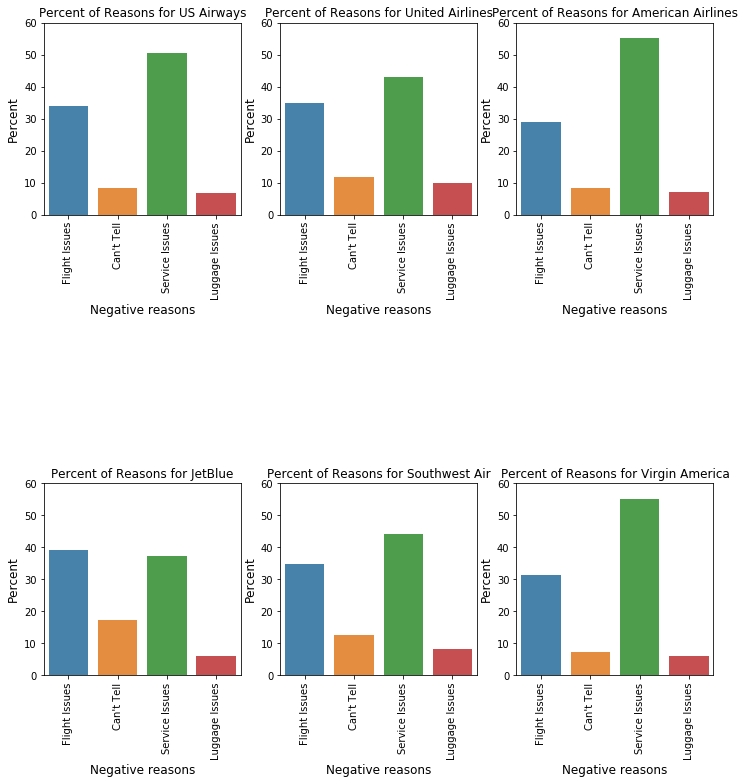

In [331]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(12, 12))

plt.subplot(331)
plot_reason('US Airways',True)
plt.subplot(332)
plot_reason('United Airlines',True)
plt.subplot(333)
plot_reason('American Airlines',True)
plt.subplot(337)
plot_reason('JetBlue',True)
plt.subplot(338)
plot_reason('Southwest Air',True)
plt.subplot(339)
plot_reason('Virgin America',True)


### Discussion
As seen from the above figures, the most two frequent negative reasons which have caused passengers dissatisfaction are **customer service issues** and **late flight**, accounting for about 40% percent of reasons. The third reason is **"can't Tell"**, which is vague and may represent any of other reasons, mentioend or not mentioned. The least important issues are **luggage issues**. However, the **lost luggage** problem is much more frequent than **damaged luggage** issue. From this anaylysis, it can be deduced that US airlines need to invest on improving their customer services and decreasing the number of late or cancelled flights.



## 5.3. Reasons why your model failed to predict the correct negative reasons
Here, we want explore the prediction data and find out the reasons which have caused the model to fail to properly predict the negative reasons. 

### Examples from the data set which the model could not accurately predict the negative reason

In [335]:
result_airline_negative_reasons[result_airline_negative_reasons['negative_reason_obs']!=result_airline_negative_reasons['negative_reason_pred']]

,airline,negative_reason_obs,negative_reason_pred,negative_reason_grouped_obs,negative_reason_grouped_pred
3,Virgin America,Can't Tell,Bad Flight,Can't Tell,Flight Issues
11,Virgin America,Late Flight,Customer Service Issue,Flight Issues,Service Issues
19,Virgin America,Customer Service Issue,Bad Flight,Service Issues,Service Issues
21,Virgin America,Can't Tell,Customer Service Issue,Can't Tell,Service Issues
31,Virgin America,Flight Booking Problems,Customer Service Issue,Service Issues,Service Issues
41,Virgin America,Late Flight,Customer Service Issue,Flight Issues,Service Issues
51,Virgin America,Can't Tell,Cancelled Flight,Can't Tell,Flight Issues
59,Virgin America,Can't Tell,Lost Luggage,Can't Tell,Flight Issues
60,Virgin America,Flight Booking Problems,Customer Service Issue,Service Issues,Service Issues
62,Virgin America,Late Flight,Lost Luggage,Flight Issues,Luggage Issues


### Discussion
The above table shows all of the tweets which the predicted negative reason is different from the observation. As obvious, there are 2108 tweets out of 9176 negative tweets which are wrongly predicted. Therefore, as data suggests the model has failed to properly predict the negative reasons. There are a few reasons which might have caused this issue, given below:
- **The curse of dimensionality**: This problem occurs in situations where the number of predictors, i.e., features, are significantly high relative to the number of observations.
- **Large number of classes**: The other fact is that here, we have 10 different classes of reasons, which in turn, decreases the accuracy of the model. This is because it is difficult for the distinguish from different classes.




To improve the accuracy of the both of created models, and address the above problems, two solutions are provided below:
- (Improve the First Model) There are a few solution which can, to some extent, reduce the problem of **the curse of dimensionality**. We can choose random sets of variables and assess their importance using **cross-validation**. We can use **ridge-regression**, the **lasso**, or you can choose a technique, such as a **support vector machine** or **random forest** that deals well with a large number of features.
- (Improve the Second Model) One way to improve the accuracy in multiclass classification problems is to combine similar classes together. As shown in section 4.8.5. after combining the reasons into four classes, the accuracy was improved by about 10%.


# References:
- Lecture notes of Introduction to Data Science and Analytics course, University of Toronto, 2018
- https://en.wikipedia.org/wiki/Curse_of_dimensionality
- https://stats.stackexchange.com/questions/10423/number-of-features-vs-number-of-observations
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
- https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
- https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets
